In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole_map, dipole, xyz_to_thetaphi, spherical_to_cartesian
import tools

### QUaia catalog

In [3]:
# parameters
mapdir = '/scratch/aew492/quasars/catalogs'
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
tab_quaia = Table.read(os.path.join(mapdir, f'quaia_G{G}.fits'), format='fits')

In [4]:
# format into healpy map
pix_idx = hp.ang2pix(NSIDE, tab_quaia['ra'], tab_quaia['dec'], lonlat=True)
map_quaia = np.bincount(pix_idx, minlength=NPIX)
np.mean(map_quaia)

26.3570556640625

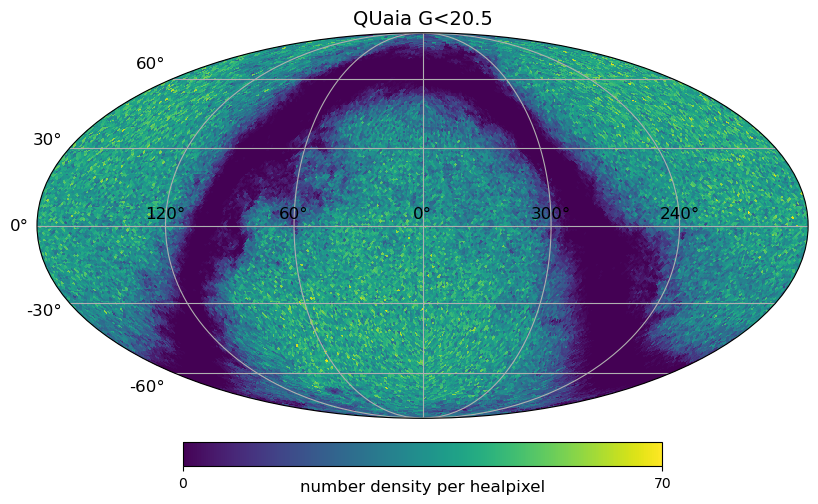

In [5]:
projview(map_quaia, title=f'QUaia G<{G}', unit='number density per healpixel',
         projection_type='mollweide', graticule=True, graticule_labels=True)

Text(0.5, 1.0, 'QUaia G<20.5 density distribution')

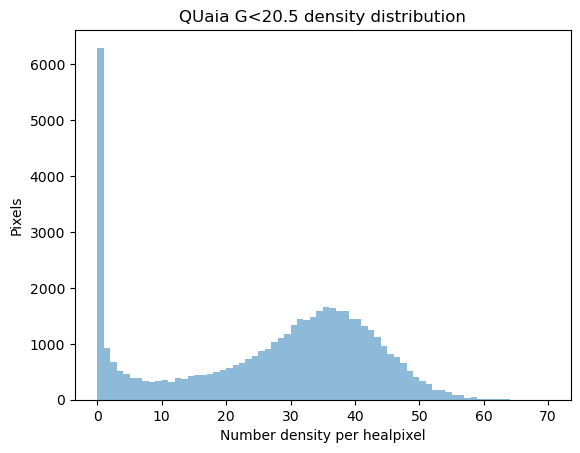

In [9]:
fig, ax = plt.subplots()
bins = np.arange(max(map_quaia)+1)  # integer bins to avoid weird counts !!
_, _, _ = ax.hist(map_quaia, bins=bins, alpha=0.5)
ax.set_xlabel('Number density per healpixel')
ax.set_ylabel('Pixels')
ax.set_title(f'QUaia G<{G} density distribution')

### selection function

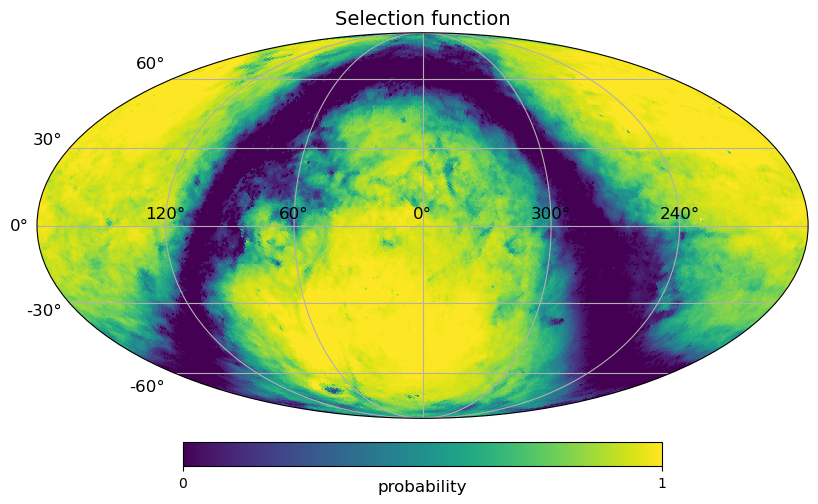

In [10]:
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))
projview(selfunc, title='Selection function', unit='probability',
        graticule=True, graticule_labels=True)

Text(0, 0.5, 'QSO density per healpixel')

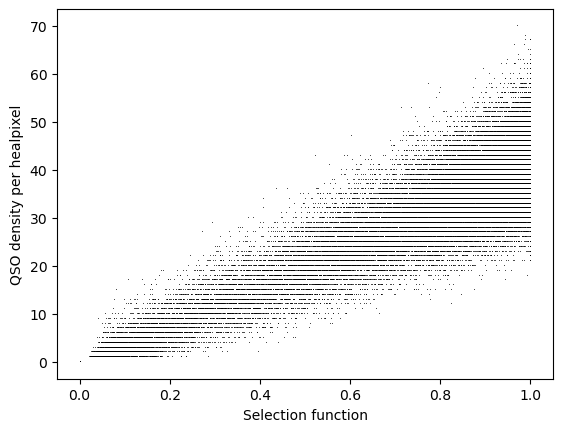

In [11]:
# scatter plot: number density in each pixel vs selection function value in that pixel
fig, ax = plt.subplots()
ax.plot(selfunc, map_quaia, marker=',', ls='None', color='k', alpha=0.7)
ax.set_xlabel('Selection function')
ax.set_ylabel('QSO density per healpixel')

### CMB dipole

In [12]:
# CMB dipole
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
cmb_dipdir.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>

In [13]:
# dipole amplitudes: zero mean for now
amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(amps, NSIDE) # match NSIDE with QUaia map

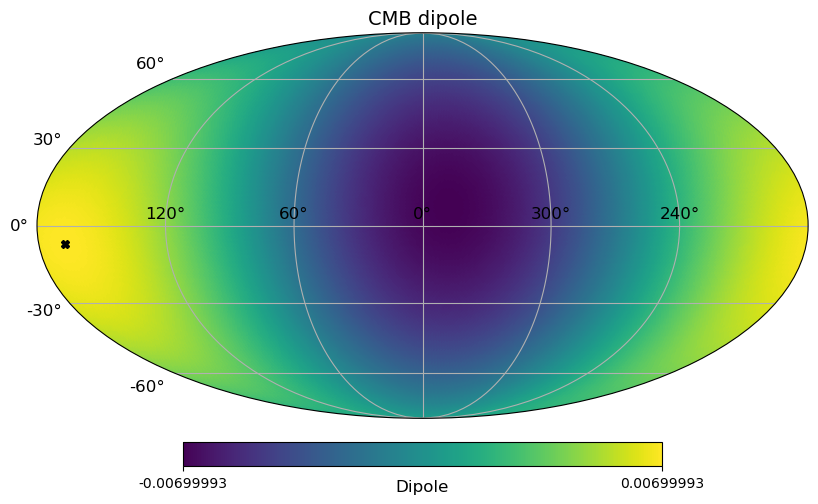

In [14]:
projview(expected_map, projection_type='mollweide', unit='Dipole',
         graticule=True, graticule_labels=True, title='CMB dipole')
newprojplot(np.pi/2-cmb_dipdir.icrs.dec.rad, cmb_dipdir.icrs.ra.rad, marker='X', color='k')

## fit a line: compare QUaia dipole to expected dipole from CMB

### 1. raw catalog (no selection function)

In [15]:
m, b = np.polyfit(expected_map, map_quaia, 1)

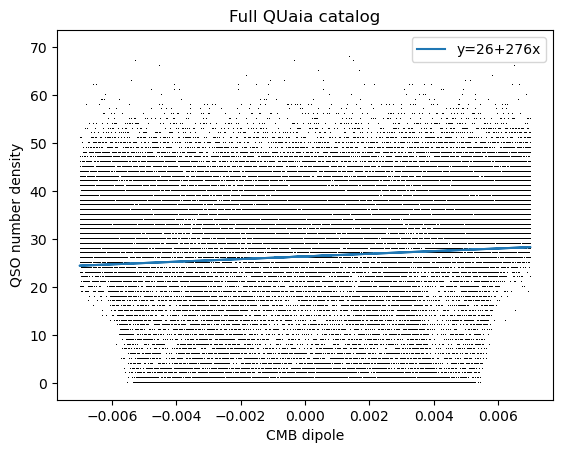

In [16]:
fig, ax = plt.subplots()
ax.plot(expected_map, map_quaia, marker=',', ls='None', color='k')
ax.plot(expected_map, b+m*expected_map, label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('Full QUaia catalog')
ax.legend()

### understanding the slope...

 (thanks Kate)

Think of the dipole as controlling the quasar number density at a location on the sky relative to the mean:

$$
n(x) = n_\mathrm{mean}\,(1+d(x))
$$

where $d$ is the dipole value at a particular location: $\bar{d}(x)=0$, and $-D\leq d(x)\leq D$ across the sky where $D$ is the overall dipole amplitude.

Since we're comparing our quasar number counts to the CMB dipole amplitude, we have $D=0.007$; where for example $d=0.001$, we expect $n=1.001\,n_\mathrm{mean}$ quasars at that position.

The slope is then $(.001\,n_\mathrm{mean})/.001 = n_\mathrm{mean}$ .

So if the slope of $n_\mathrm{QSO}$ vs. $d_\mathrm{CMB}$ is $n_\mathrm{mean}$, then we have the expected dipole. But if for example the slope is $2\,n_\mathrm{mean}$, we have twice the expected dipole!

### 2. raw catalog; fit where completeness > 0.5

In [17]:
idx_clean = np.where(selfunc > 0.5)
m, b = np.polyfit(expected_map[idx_clean], map_quaia[idx_clean], 1)

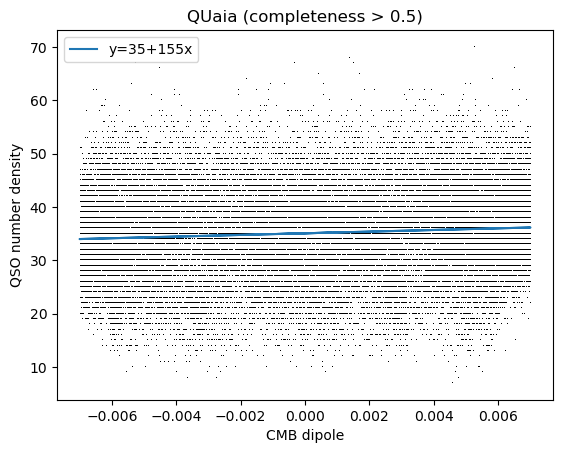

In [18]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_clean], map_quaia[idx_clean], marker=',', ls='None', color='k')
ax.plot(expected_map[idx_clean], b+m*expected_map[idx_clean], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('QUaia (completeness > 0.5)')
ax.legend()

### 3. catalog divided by completeness (selection function)

In [19]:
map_quaia_expected = map_quaia / selfunc

/state/partition1/job-35375093/ipykernel_2513486/921411248.py:1: RuntimeWarning: invalid value encountered in divide
  map_quaia_expected = map_quaia / selfunc


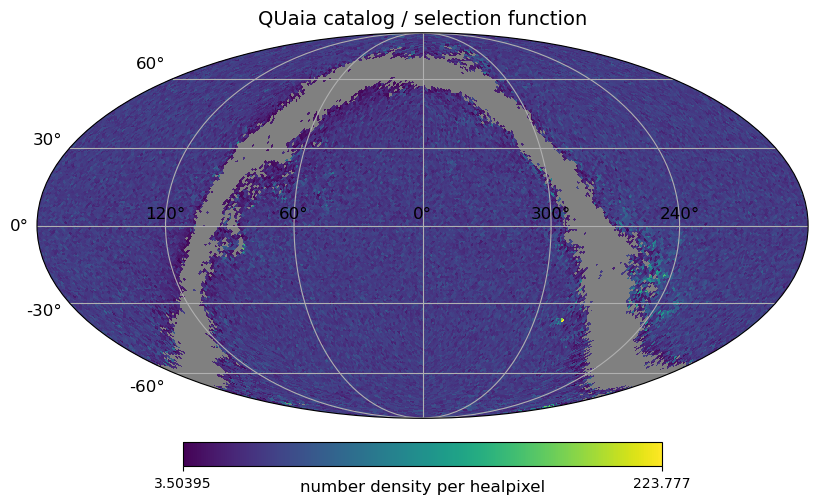

In [20]:
projview(map_quaia_expected, title='QUaia catalog / selection function', unit='number density per healpixel',
        graticule=True, graticule_labels=True)

In [21]:
idx_to_fit = np.where(~np.isnan(map_quaia_expected))
print(len(idx_to_fit[0])/len(map_quaia_expected))
m, b = np.polyfit(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], 1)

0.8718465169270834


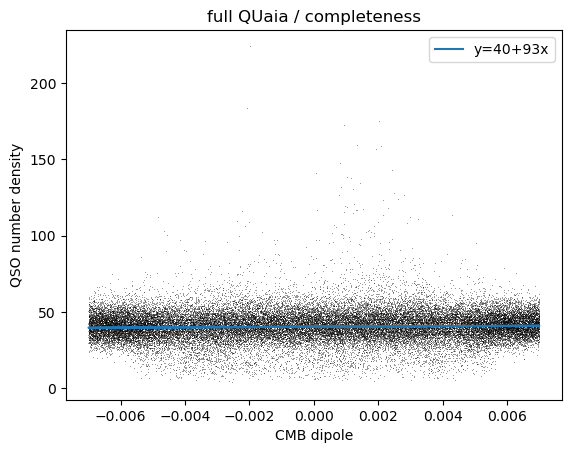

In [22]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map[idx_to_fit], b+m*expected_map[idx_to_fit], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('full QUaia / completeness')
ax.legend()

Roughly twice the expected dipole amplitude --> ~ Secrest's result 

### 4. catalog divided by completeness; weight by completeness

In [23]:
m, b = np.polyfit(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], 1, w=selfunc[idx_to_fit])

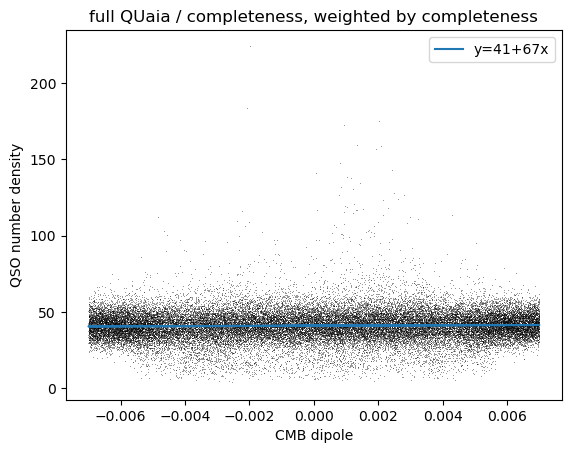

In [24]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map[idx_to_fit], b+m*expected_map[idx_to_fit], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('full QUaia / completeness, weighted by completeness')
ax.legend()

### 5. catalog / completeness & expected dipole * completeness

In [25]:
expected_map_selfunc = expected_map * selfunc

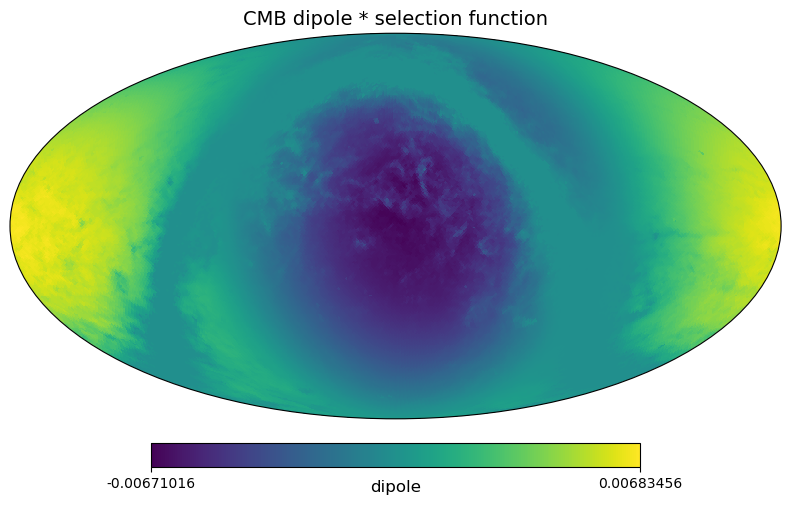

In [26]:
projview(expected_map_selfunc, title='CMB dipole * selection function', unit='dipole')

In [27]:
m, b = np.polyfit(expected_map_selfunc[idx_to_fit], map_quaia_expected[idx_to_fit], 1)

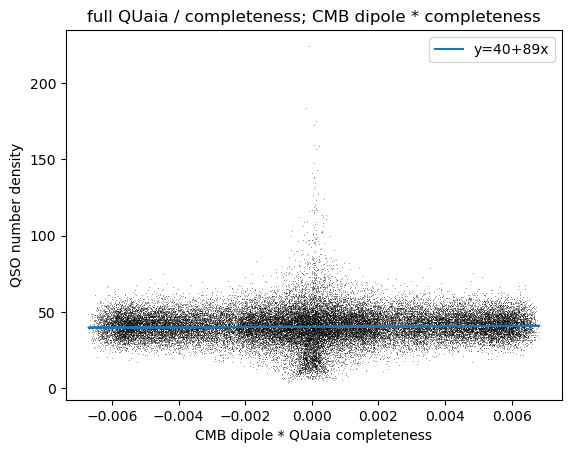

In [28]:
fig, ax = plt.subplots()
ax.plot(expected_map_selfunc[idx_to_fit], map_quaia_expected[idx_to_fit], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map_selfunc[idx_to_fit], b+m*expected_map_selfunc[idx_to_fit], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole * QUaia completeness')
ax.set_ylabel('QSO number density')
ax.set_title('full QUaia / completeness; CMB dipole * completeness')
ax.legend()

### 6. raw catalog; expected dipole * completeness; weight by completeness

In [29]:
m, b = np.polyfit(expected_map_selfunc, map_quaia, 1, w=selfunc)

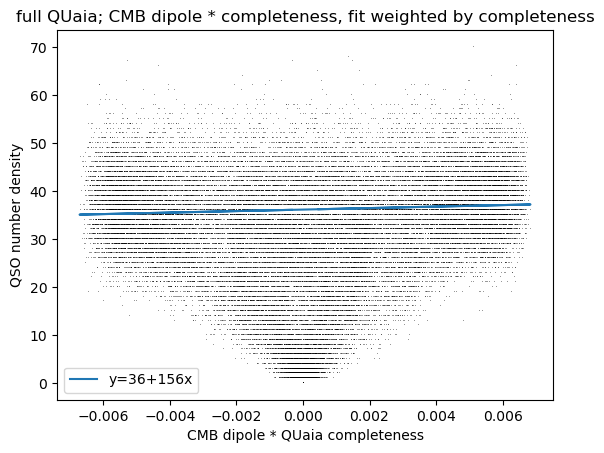

In [30]:
fig, ax = plt.subplots()
ax.plot(expected_map_selfunc, map_quaia, marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map_selfunc, b+m*expected_map_selfunc, label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole * QUaia completeness')
ax.set_ylabel('QSO number density')
ax.set_title('full QUaia; CMB dipole * completeness, fit weighted by completeness')
ax.legend()

### 7. QUaia divided by completeness; fit where completeness > 0.5

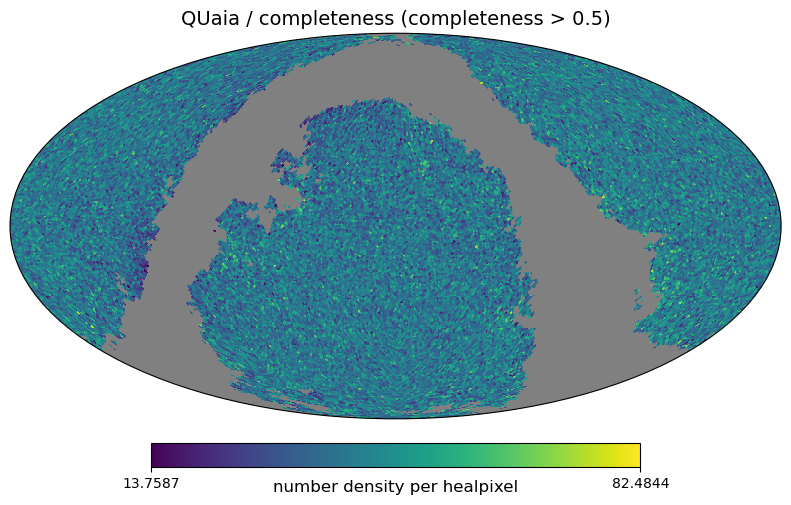

In [35]:
map_quaia_expected_clean = np.copy(map_quaia_expected)
map_quaia_expected_clean[np.where(selfunc<0.5)] = np.nan
projview(map_quaia_expected_clean, title='QUaia / completeness (completeness > 0.5)',
         unit='number density per healpixel')

In [36]:
m, b = np.polyfit(expected_map[idx_clean], map_quaia_expected_clean[idx_clean], 1)

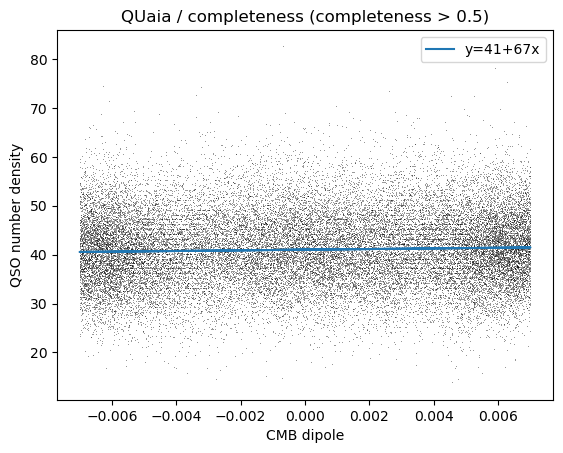

In [37]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_clean], map_quaia_expected_clean[idx_clean], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map[idx_clean], b+m*expected_map[idx_clean], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('QUaia / completeness (completeness > 0.5)')
ax.legend()

### 8. QUaia divided by completeness; fit where completeness > 0.5; weight by completeness

In [38]:
m, b = np.polyfit(expected_map[idx_clean], map_quaia_expected_clean[idx_clean], 1, w=selfunc[idx_clean])

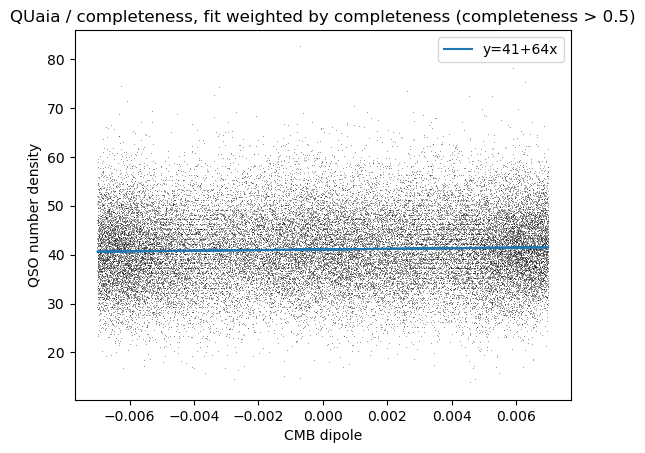

In [39]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_clean], map_quaia_expected_clean[idx_clean], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map[idx_clean], b+m*expected_map[idx_clean], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('QUaia / completeness, fit weighted by completeness (completeness > 0.5)')
ax.legend()

### 9. QUaia divided by completeness; galactic plane cut (|b|>30deg)

In [40]:
# get coords of each pixel
ras, decs = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)
print(min(ras), max(ras), min(decs), max(decs))
coords = SkyCoord(ras, decs, unit='deg', frame='icrs')

0.0 359.296875 -89.2690292915739 89.2690292915739


In [41]:
idx_galcut = (np.abs(coords.galactic.b) > 30*u.deg)

In [42]:
map_quaia_expected_galcut = np.copy(map_quaia_expected)
map_quaia_expected_galcut[~idx_galcut] = np.nan

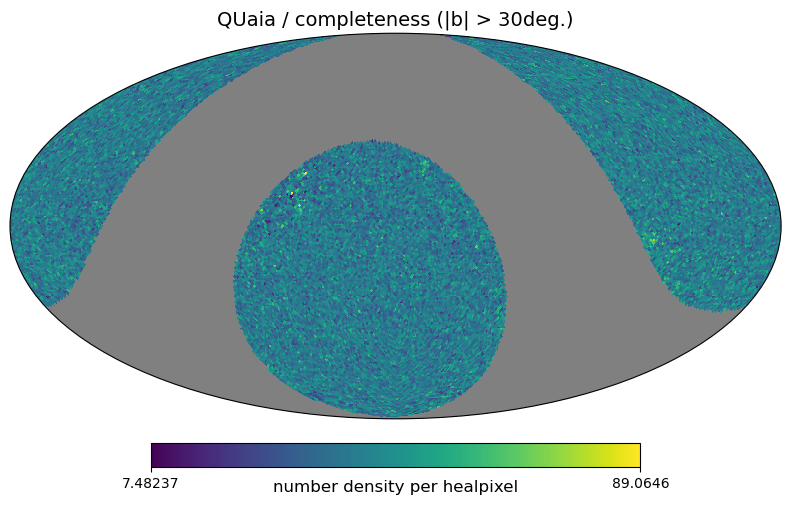

In [43]:
projview(map_quaia_expected_galcut, title='QUaia / completeness (|b| > 30deg.)',
         unit='number density per healpixel')

In [44]:
m, b = np.polyfit(expected_map[idx_galcut], map_quaia_expected_galcut[idx_galcut], 1)

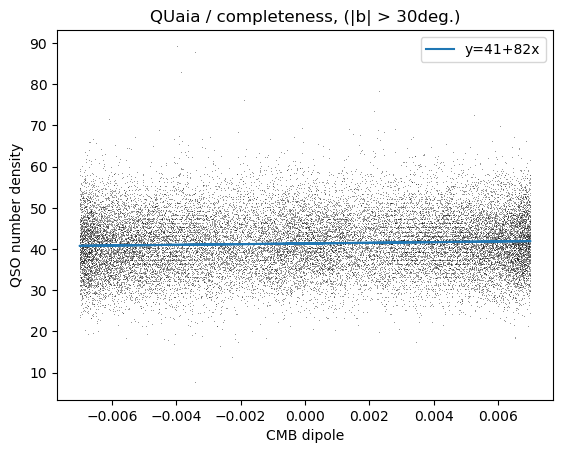

In [45]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_galcut], map_quaia_expected_galcut[idx_galcut], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map[idx_galcut], b+m*expected_map[idx_galcut], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('QUaia / completeness, (|b| > 30deg.)')
ax.legend()

### 10. QUaia divided by completeness; galactic plane cut; weight by completeness

In [46]:
m, b = np.polyfit(expected_map[idx_galcut], map_quaia_expected_galcut[idx_galcut], 1, w=selfunc[idx_galcut])

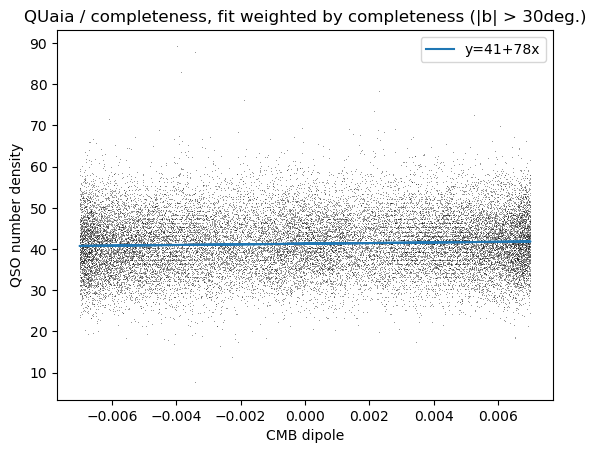

In [47]:
fig, ax = plt.subplots()
ax.plot(expected_map[idx_galcut], map_quaia_expected_galcut[idx_galcut], marker=',', ls='None', color='k', alpha=0.4)
ax.plot(expected_map[idx_galcut], b+m*expected_map[idx_galcut], label=f'y={b:.0f}+{m:.0f}x')
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO number density')
ax.set_title('QUaia / completeness, fit weighted by completeness (|b| > 30deg.)')
ax.legend()